In [21]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Lasso
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.pipeline import Pipeline

In [20]:
import os

# Create a folder to save figures
os.makedirs('fig', exist_ok=True)

# Read data
data = pd.read_csv('enhanced_anxiety_dataset(modified).csv')

# Data preprocessing
# Check and handle missing values
print("Missing data status:")
print(data.isnull().sum())


Missing data status:
Age                                  0
Sleep Hours                          0
Physical Activity (hrs/week)         0
Caffeine Intake (mg/day)             0
Alcohol Consumption (drinks/week)    0
Smoking                              0
Family History of Anxiety            0
Stress Level (1-10)                  0
Heart Rate (bpm)                     0
Breathing Rate (breaths/min)         0
Sweating Level (1-5)                 0
Dizziness                            0
Medication                           0
Therapy Sessions (per month)         0
Recent Major Life Event              0
Diet Quality (1-10)                  0
Anxiety Level (1-10)                 0
dtype: int64


In [23]:
# Prepare features and target variable
X = data.drop(columns=['Anxiety Level (1-10)'])
y = data['Anxiety Level (1-10)']

# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Create a pipeline for standardization + Lasso regression
scaler = StandardScaler()
lasso = Lasso(random_state=42)
pipeline = Pipeline([('scaler', scaler), ('lasso', lasso)])

# Define parameter grid for hyperparameter tuning
param_grid = {
    'lasso__alpha': np.logspace(-4, 2, 100)  # Try different alpha values
}

# Use grid search to find the best parameters
grid = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
grid.fit(X_train, y_train)

# Get the best alpha value
best_alpha = grid.best_params_['lasso__alpha']
print(f'Optimal alpha value for LASSO: {best_alpha}')

Optimal alpha value for LASSO: 0.0001


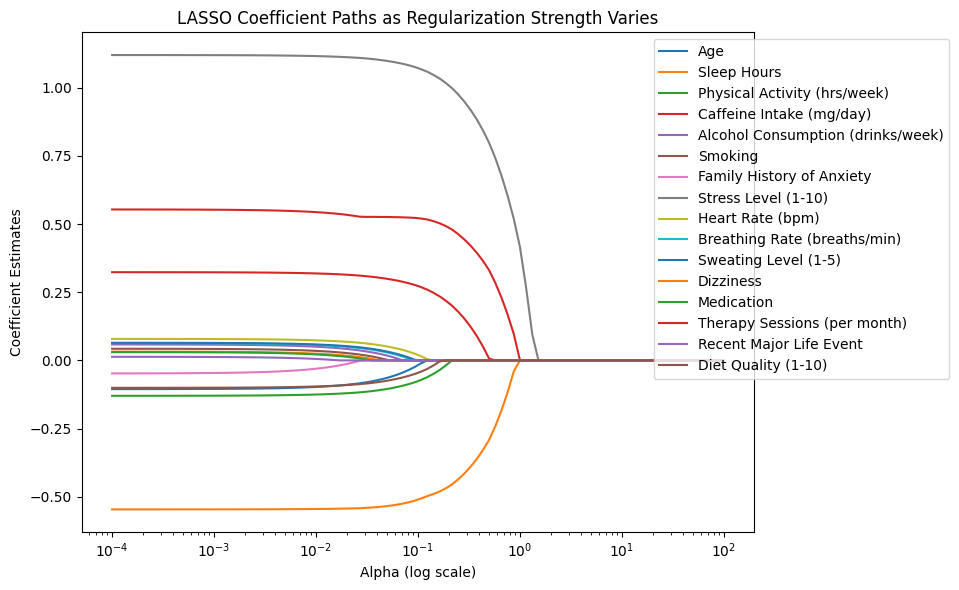

In [24]:
# Plot the trajectory of LASSO coefficients as alpha changes
alphas = np.logspace(-4, 2, 100)
coefs = []

for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42)
    pipeline = Pipeline([('scaler', scaler), ('lasso', lasso)])
    pipeline.fit(X_train, y_train)
    coefs.append(pipeline.named_steps['lasso'].coef_)

plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.plot(alphas, coefs)
ax.set_xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Coefficient Estimates')
plt.title('LASSO Coefficient Paths as Regularization Strength Varies')
plt.legend(X.columns, loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('fig/lasso_coef_path.png', dpi=300, bbox_inches='tight')
plt.show()

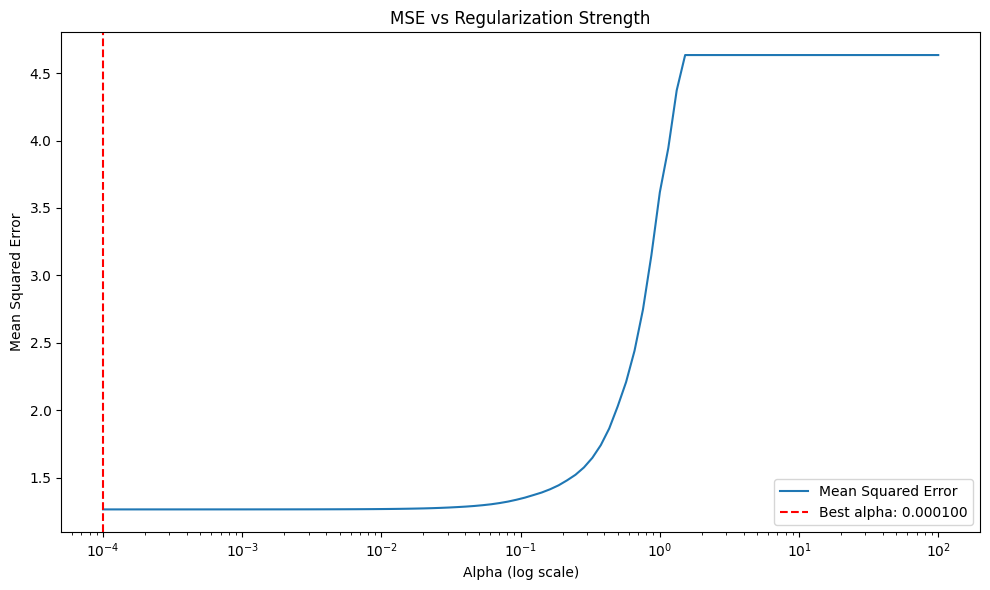

In [25]:
# Plot the curve of MSE as alpha changes
mse = []
for alpha in alphas:
    lasso = Lasso(alpha=alpha, random_state=42)
    pipeline = Pipeline([('scaler', scaler), ('lasso', lasso)])
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    mse.append(mean_squared_error(y_test, y_pred))

plt.figure(figsize=(10, 6))
plt.plot(alphas, mse, label='Mean Squared Error')
plt.axvline(x=best_alpha, color='red', linestyle='--', label=f'Best alpha: {best_alpha:.6f}')
plt.xscale('log')
plt.xlabel('Alpha (log scale)')
plt.ylabel('Mean Squared Error')
plt.title('MSE vs Regularization Strength')
plt.legend()
plt.tight_layout()
plt.savefig('fig/lasso_mse.png', dpi=300, bbox_inches='tight')
plt.show()



Training RMSE: 1.13
Test RMSE: 1.12
Training R²: 0.72
Test R²: 0.73

Features selected by LASSO (16/16):
                              Feature  Coefficient  Abs_Coefficient
7                 Stress Level (1-10)     1.120332         1.120332
13       Therapy Sessions (per month)     0.553768         0.553768
1                         Sleep Hours    -0.546693         0.546693
3            Caffeine Intake (mg/day)     0.323661         0.323661
2        Physical Activity (hrs/week)    -0.129860         0.129860
0                                 Age    -0.105328         0.105328
15                Diet Quality (1-10)    -0.100635         0.100635
8                    Heart Rate (bpm)     0.078885         0.078885
10               Sweating Level (1-5)     0.064629         0.064629
9        Breathing Rate (breaths/min)     0.063320         0.063320
4   Alcohol Consumption (drinks/week)     0.058374         0.058374
6           Family History of Anxiety    -0.047740         0.047740
5          

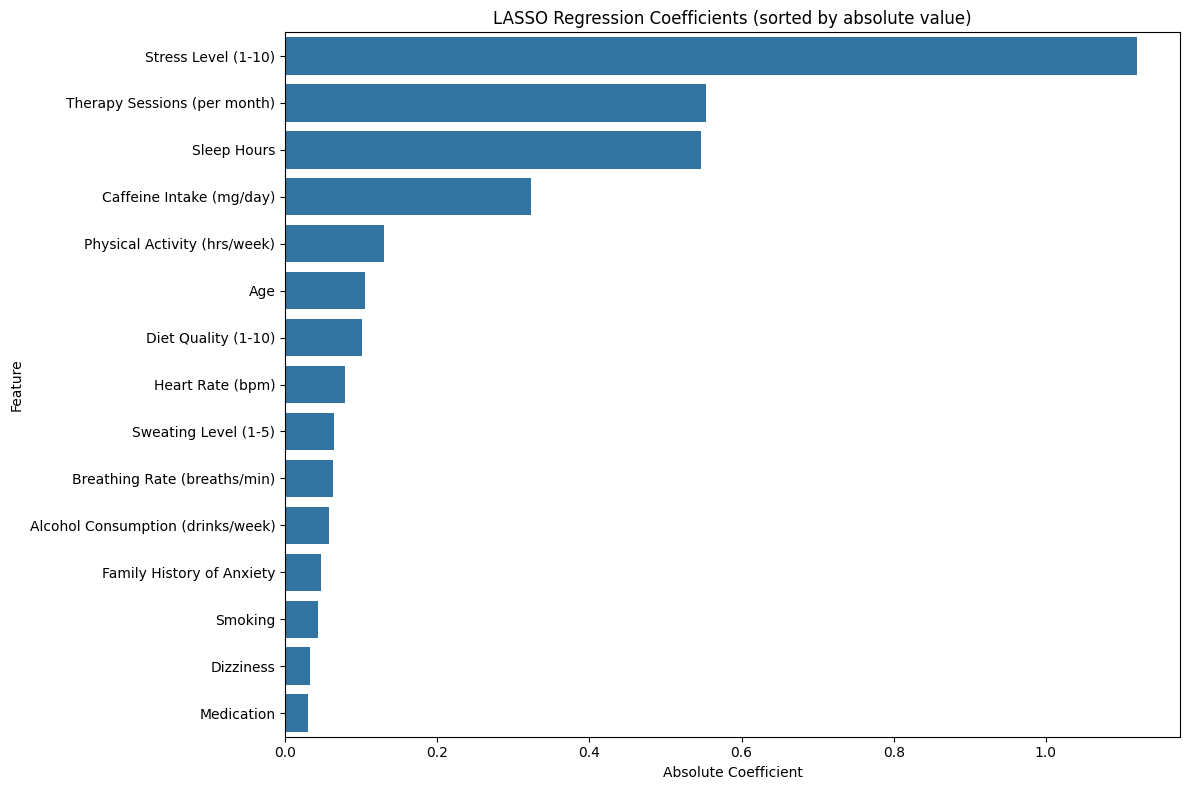

In [26]:
# Use the best model for prediction
y_train_pred = grid.predict(X_train)
y_test_pred = grid.predict(X_test)

# Calculate and print performance metrics
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

print(f'Training RMSE: {train_rmse:.2f}')
print(f'Test RMSE: {test_rmse:.2f}')
print(f'Training R²: {train_r2:.2f}')
print(f'Test R²: {test_r2:.2f}')

# Get coefficients of the best model
lasso_coef = grid.best_estimator_.named_steps['lasso'].coef_
coef_df = pd.DataFrame({
    'Feature': X.columns,
    'Coefficient': lasso_coef,
    'Abs_Coefficient': np.abs(lasso_coef)
})

# Sort by absolute value of coefficients
coef_df = coef_df.sort_values('Abs_Coefficient', ascending=False)

# Print features with non-zero coefficients
non_zero_coefs = coef_df[coef_df['Coefficient'] != 0]
print(f"\nFeatures selected by LASSO ({len(non_zero_coefs)}/{len(coef_df)}):")
print(non_zero_coefs)

# Visualize coefficients
plt.figure(figsize=(12, 8))
sns.barplot(x='Abs_Coefficient', y='Feature', data=coef_df.head(15))
plt.title('LASSO Regression Coefficients (sorted by absolute value)')
plt.xlabel('Absolute Coefficient')
plt.ylabel('Feature')
plt.tight_layout()
plt.savefig('fig/lasso_coefficients.png', dpi=300, bbox_inches='tight')
plt.show()

C:\Users\18117\AppData\Local\Temp\ipykernel_33336\417724406.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted_coef, palette='viridis')


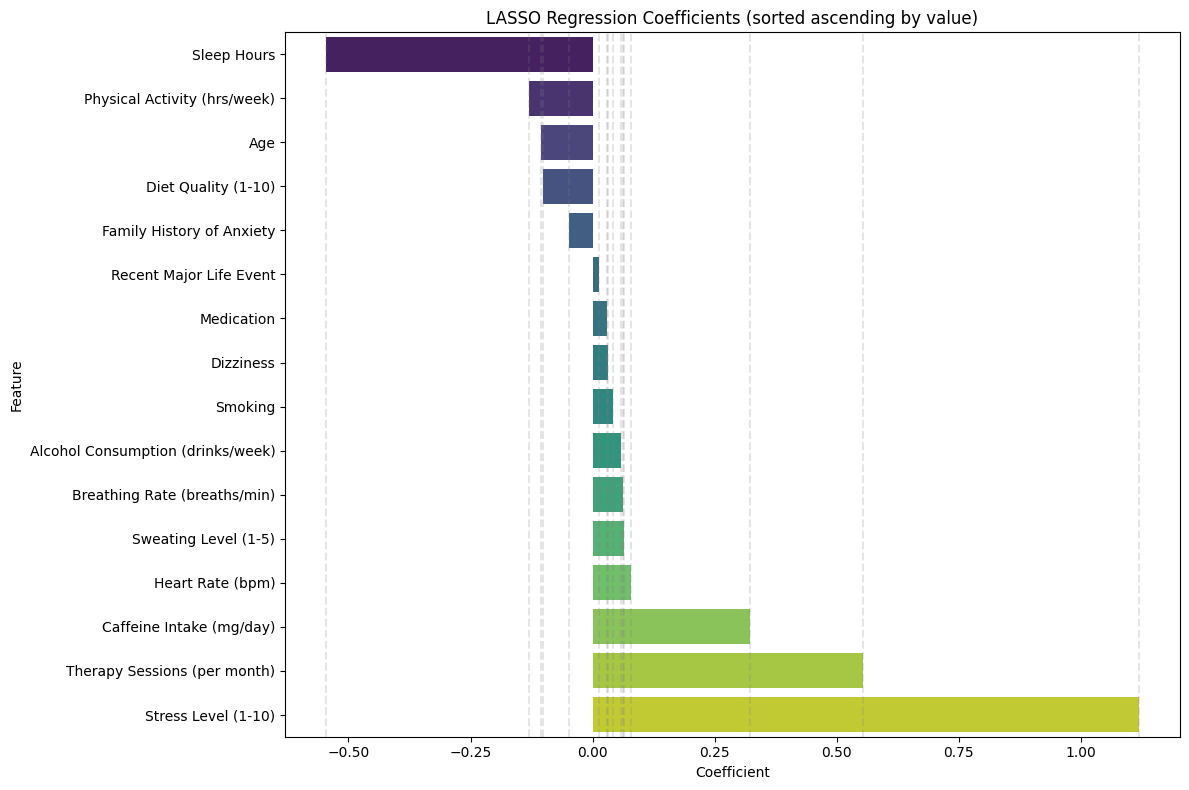

In [34]:
plt.figure(figsize=(12, 8))
coef_df_sorted_coef = coef_df_sorted.sort_values('Coefficient', ascending=True)
sns.barplot(x='Coefficient', y='Feature', data=coef_df_sorted_coef, palette='viridis')

plt.title('LASSO Regression Coefficients (sorted ascending by value)')
plt.xlabel('Coefficient')
plt.ylabel('Feature')

for x in coef_df_sorted_coef['Coefficient']:
    plt.axvline(x=x, color='gray', linestyle='--', alpha=0.2)

plt.tight_layout()
plt.savefig('fig/lasso_coefficients_sorted_coef.png', dpi=300, bbox_inches='tight')
plt.show()


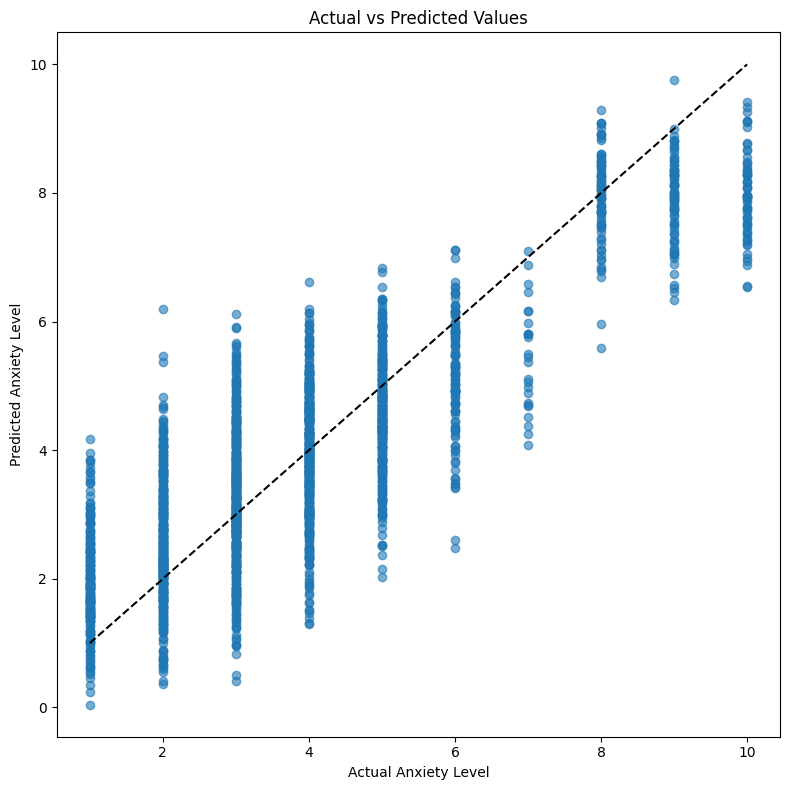

In [36]:
# Plot Actual vs Predicted Values with a single color
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_test_pred, color='tab:blue', alpha=0.6)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel('Actual Anxiety Level')
plt.ylabel('Predicted Anxiety Level')
plt.title('Actual vs Predicted Values')
plt.tight_layout()
plt.savefig('fig/actual_vs_predicted.png', dpi=300, bbox_inches='tight')
plt.show()


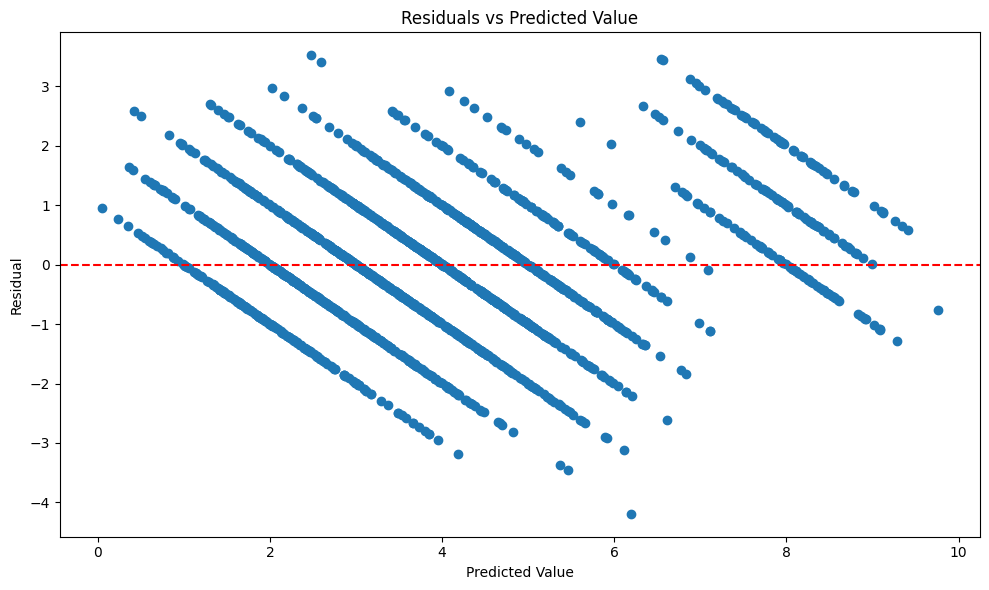

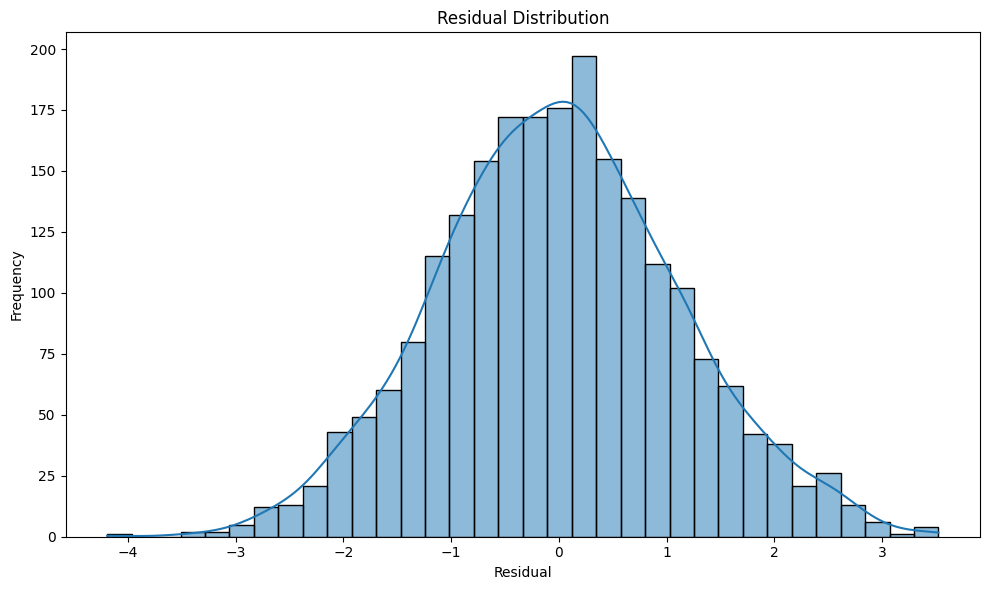

In [28]:
# Plot residuals
residuals = y_test - y_test_pred
plt.figure(figsize=(10, 6))
plt.scatter(y_test_pred, residuals)
plt.axhline(y=0, color='r', linestyle='--')
plt.xlabel('Predicted Value')
plt.ylabel('Residual')
plt.title('Residuals vs Predicted Value')
plt.tight_layout()
plt.savefig('fig/residuals.png', dpi=300, bbox_inches='tight')
plt.show()

# Plot residual distribution
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True)
plt.xlabel('Residual')
plt.ylabel('Frequency')
plt.title('Residual Distribution')
plt.tight_layout()
plt.savefig('fig/residuals_dist.png', dpi=300, bbox_inches='tight')
plt.show()